In [1]:
! pip install pydub
! pip install -U datasets
! pip install -U accelerate
! pip install -U transformers

In [2]:
! pip install numpy==1.23.4.

In [3]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd

import torchaudio
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch

In [128]:

print_samples = 10 
printed_samples= 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    if (printed_samples == 10):
        break
    for filename in filenames:
        if (printed_samples == 10):
            break
        print(os.path.join(dirname, filename))
        printed_samples = printed_samples + 1

/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F13A20.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F23A06.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F24N09.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F24S05.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F21W01.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F24S01.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F24A43.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F05S01.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F09N03.wav
/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F03S15.wav


In [129]:
label_to_one_hot = {'A': [1, 0, 0, 0, 0, 0], 'N': [0, 1, 0, 0, 0, 0], 'S': [0, 0, 1, 0, 0, 0], 'F': [0, 0, 0, 1, 0, 0],
                    'W': [0, 0, 0, 0, 1, 0], 'H': [0, 0, 0, 0, 0, 1]}

class GeneralDataset(Dataset):
    def __init__(self, male_directory, female_directory, target_sample_rate, max_len=None):
        self.male_files = [(os.path.join(male_directory, f), 'male') for f in os.listdir(male_directory)]
        self.female_files = [(os.path.join(female_directory, f), 'female') for f in os.listdir(female_directory)]
        self.files = self.male_files + self.female_files
        self.target_sample_rate = target_sample_rate
        self.max_len = max_len

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, gender = self.files[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
        waveform = resampler(waveform)
        label = self.extract_label_char_from_filename(file_path)
        waveform = waveform.squeeze().numpy()
        return waveform, label
    @staticmethod
    def extract_label_char_from_filename(filename):
        char_label = filename.split('/')[-1][3]
        return char_label
    @staticmethod
    def extract_label_onehot_from_filename(filename):
        return GeneralDataset.label_char_to_one_hot(GeneralDataset.extract_label_char_from_filename(filename))
    @staticmethod
    def label_char_to_one_hot(char):
        return torch.Tensor(label_to_one_hot[char])

male_data_directory = '/kaggle/input/shemo-persian-speech-emotion-detection-database/male'
female_data_directory = '/kaggle/input/shemo-persian-speech-emotion-detection-database/female'

target_sample_rate = 16000  
max_waveform_length =  180000
shemo_dataset = GeneralDataset(
    male_directory=male_data_directory,
    female_directory=female_data_directory,
    target_sample_rate=target_sample_rate,
    max_len=max_waveform_length
)


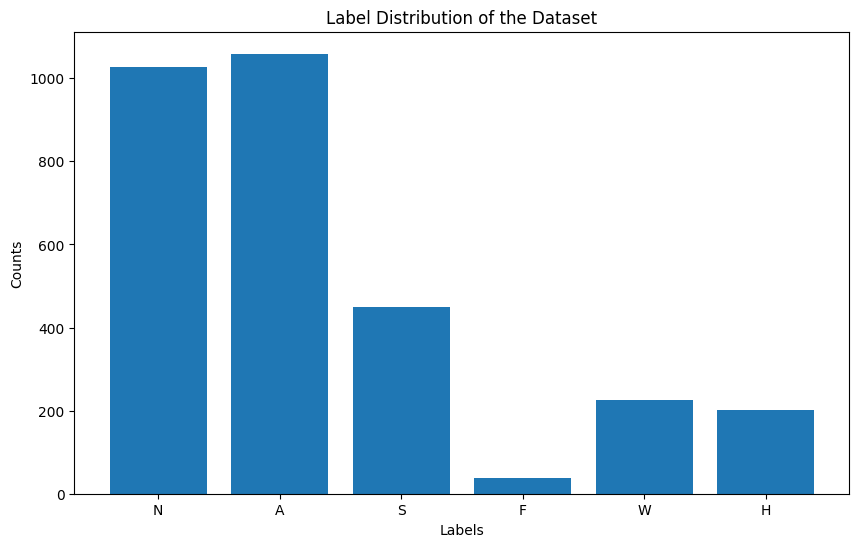

In [6]:

label_counts = Counter()
for file in shemo_dataset.files:
    label = GeneralDataset.extract_label_char_from_filename(file[0])
    label_counts[label] += 1

labels, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution of the Dataset')
plt.show()

In [7]:

signals = []
labels = []
sample_rates = []
for waveform, label in shemo_dataset:
    signals.append(waveform.flatten())
    labels.append(label)

df = pd.DataFrame({
    'signal': signals,
    'label': labels
})


In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, 
                                         random_state=44, stratify=df['label'])
train_data, val_data = train_test_split(train_data, test_size=0.5,
                                       random_state=44, stratify=train_data['label'])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
from sklearn.utils import resample
import librosa
df_majority = train_data[train_data.label == train_data.label.mode()[0]]
df_minority_classes = [train_data[train_data.label == lbl] for lbl in train_data.label.unique() if lbl != train_data.label.mode()[0]]

df_minority_upsampled = [resample(df_minority, 
                                  replace=True,    
                                  n_samples=len(df_majority),
                                  random_state=44) for df_minority in df_minority_classes]

df_upsampled = pd.concat([df_majority] + df_minority_upsampled)
df_upsampled = df_upsampled.sample(frac=1, random_state=44).reset_index(drop=True)
df_train  = df_upsampled

In [131]:
import numpy as np
import pandas as pd
import librosa
def vectorized_add_noise(data):
    noise = np.random.randn(len(data))
    data_noise = data + 0.005 * noise
    return data_noise
def vectorized_shift_time(data, sampling_rate, shift_max):
    shift = np.random.randint(sampling_rate * shift_max)
    return np.roll(data, shift)
def vectorized_change_pitch_and_speed(data):
    return librosa.effects.pitch_shift(data, sr=target_sample_rate, n_steps=np.random.randint(-1, 2))

def apply_augmentation_vectorized(row):
    if row["label"] != df_majority.label.mode()[0]:
        row["signal"] = vectorized_add_noise(row["signal"])
        row["signal"] = vectorized_shift_time(row["signal"], sampling_rate=target_sample_rate, shift_max=0.2)
        row["signal"] = vectorized_change_pitch_and_speed(row["signal"])
        row["signal"] = row["signal"].astype('float32')
    return row
df_train = df_train.apply(apply_augmentation_vectorized, axis=1)
test_data  = test_data.apply(apply_augmentation_vectorized, axis=1)
val_data   = val_data.apply(apply_augmentation_vectorized, axis=1)

In [132]:
from pydub import AudioSegment
import numpy as np
import pandas as pd

def play_voice(df, index):
    audio_data = df.iloc[index]['signal']
    audio_data = (audio_data * 32767).astype(np.int16) 
    audio = AudioSegment(
        audio_data.tobytes(),
        frame_rate=5000, 
        sample_width=2,
        channels=1
    )
    return audio
play_voice(df_train, 1)

In [133]:
df_train['signal'].iloc[1].shape

(175219,)

In [134]:
df_train.iloc[0]['signal'].shape

(9907,)

<Axes: >

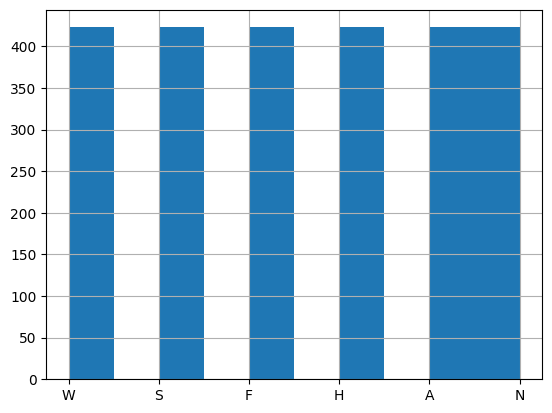

In [135]:
df_train['label'].hist()

In [136]:
label_to_one_hot = {'A': [1, 0, 0, 0, 0, 0], 'N': [0, 1, 0, 0, 0, 0], 'S': [0, 0, 1, 0, 0, 0], 'F': [0, 0, 0, 1, 0, 0],
                    'W': [0, 0, 0, 0, 1, 0], 'H': [0, 0, 0, 0, 0, 1]}
labels  = list(label_to_one_hot.keys())
labels

['A', 'N', 'S', 'F', 'W', 'H']

In [137]:
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
model_name = "facebook/hubert-base-ls960"
pooling_mode = "mean"
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(labels),
    label2id={label: i for i, label in enumerate(labels)},
    id2label={i: label for i, label in enumerate(labels)},
    finetuning_task="wav2vec2_clf",
)

setattr(config, "pooling_mode", pooling_mode)
# setattr(config, "mask_length", 1)

In [138]:
config

HubertConfig {
  "_name_or_path": "facebook/hubert-base-ls960",
  "activation_dropout": 0.1,
  "apply_spec_augment": true,
  "architectures": [
    "HubertModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "feat_proj_layer_norm": true,
  "final_dropout": 0.1,
  "finetuning_task": "wav2vec2_clf",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout": 0.1,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "A",
 

In [139]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

In [140]:
# feature_extractor.return_attention_mask=True
feature_extractor.sampling_rate = target_sample_rate
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [141]:
from datasets import Dataset
val_dataset = Dataset.from_pandas(val_data)
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(test_data)

In [21]:
pip install --upgrade datasets

Note: you may need to restart the kernel to use updated packages.


In [22]:
train_dataset.save_to_disk('./train_2.f')
val_dataset.save_to_disk('./val_2.f')
test_dataset.save_to_disk('./test_3.f')

Saving the dataset (0/2 shards):   0%|          | 0/2538 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

In [23]:
from datasets import load_from_disk
train_dataset = load_from_disk('./train_2.f')
val_dataset = load_from_disk('./val_2.f')
test_dataset = load_from_disk('./test_3.f')

In [142]:
# segments_ = []
import numpy as np 
def preprocess_function(segments):
    features = segments['signal']
    result = feature_extractor(features, sampling_rate=feature_extractor.sampling_rate)
    target_indices = [labels.index(segment) for segment in segments['label']]
    result['labels'] = target_indices
    return result

train_dataset = train_dataset.map(preprocess_function,batched=True,batch_size=1, num_proc=6)
val_dataset = val_dataset.map(preprocess_function,batched=True ,batch_size=1, num_proc=6)
test_dataset = test_dataset.map(preprocess_function,batched=True, batch_size=1, num_proc=6)

Map (num_proc=6):   0%|          | 0/2538 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/1200 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/600 [00:00<?, ? examples/s]

In [144]:
len(train_dataset[0]['signal'])

9907

In [145]:
from torch import nn
import torch.nn as nn
from dataclasses import dataclass
from typing import *
from torch.nn import BCEWithLogitsLoss
from transformers.file_utils import ModelOutput
from transformers.models.hubert.modeling_hubert import HubertPreTrainedModel,HubertModel
criterion =nn.CrossEntropyLoss()

class SpeechClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dropout = nn.Dropout(config.final_dropout)
        self.dropout_2 = nn.Dropout(config.final_dropout)
        self.linear = nn.Linear(config.hidden_size, config.hidden_size * 6)
        self.linear_2 = nn.Linear(config.hidden_size * 6 , config.num_labels)

    def forward(self, features, **kwargs):
        x = self.linear(features)
        x = torch.relu(x)
        x = self.linear_2(x)
        return x
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
        
class EmotionClassifierHubert(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config
        self.hubert = HubertModel(config)
        self.hubert.feature_extractor._freeze_parameters()
        self.classifier = SpeechClassifier(config)
        self.init_weights()
 
    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        input_values=input_values.to("cuda")
        outputs = self.hubert(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict)
        hidden_states = outputs.last_hidden_state
        hidden_states = torch.mean(hidden_states, dim=1)
        logits = self.classifier(hidden_states)
        loss = None
        labels = labels.long()
        loss = criterion(logits, labels)
        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [146]:

model = EmotionClassifierHubert.from_pretrained(
    model_name,
    config=config,
)

Some weights of EmotionClassifierHubert were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.linear.bias', 'classifier.linear.weight', 'classifier.linear_2.weight', 'classifier.linear_2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
from transformers import EvalPrediction
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    true_labels = p.label_ids
    print("Preds:", preds[:10], "True Labels:", true_labels[:10])
    accuracy = (preds == true_labels).astype(np.float32).mean().item()
    unique_preds, counts_preds = np.unique(preds, return_counts=True)
    unique_labels, counts_labels = np.unique(true_labels, return_counts=True)
    print("Unique Predictions:", dict(zip(unique_preds, counts_preds)))
    print("Unique True Labels:", dict(zip(unique_labels, counts_labels)))

    return {"accuracy": accuracy}


In [148]:
class CustomDataLoader:

    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, features):
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]
        batch = self.feature_extractor.pad(
            input_features,
            padding="longest",
            return_tensors="pt",
        )
        num_classes = len(labels)
#         one_hot_vectors = torch.nn.functional.one_hot(torch.tensor(label_features, dtype=d_type), num_classes=num_classes)
        batch["labels"] = torch.tensor(label_features,dtype=torch.long)
        
        return batch

data_loader = CustomDataLoader(feature_extractor)
data_loader


In [149]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir='./output/',
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=1e12,
    eval_steps=200,
    logging_steps=100,
    learning_rate=0.00001,
    save_total_limit=0,
    do_train=True,
    do_eval=True,
    do_predict=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,~
    data_collator=data_loader,
    compute_metrics=compute_metrics 
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [119]:
# model_save_path = "./"
# torch.save(model.state_dict(), model_save_path + "/model_state_dict.pth")
# model.save_pretrained(model_save_path)


In [150]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to("cuda")
trainer.train()

cuda


Step,Training Loss,Validation Loss,Accuracy
200,1.428100,1.361068,0.540000
400,1.227500,1.425526,0.613333
600,1.173700,0.943879,0.699167
800,1.041500,0.963048,0.699167
1000,1.084100,0.811514,0.730833
1200,0.982100,0.717764,0.750000
1400,0.892100,0.821080,0.743333
1600,0.793000,0.746699,0.748333
1800,0.893900,0.734585,0.749167
2000,0.827500,0.705028,0.768333


Preds: [0 1 4 1 0 0 0 4 0 0] True Labels: [0 1 5 1 0 1 0 2 0 1]
Unique Predictions: {0: 733, 1: 278, 2: 3, 3: 3, 4: 109, 5: 74}
Unique True Labels: {0: 424, 1: 411, 2: 179, 3: 16, 4: 90, 5: 80}
Preds: [0 1 0 1 0 0 0 4 0 1] True Labels: [0 1 5 1 0 1 0 2 0 1]
Unique Predictions: {0: 665, 1: 286, 2: 45, 3: 44, 4: 102, 5: 58}
Unique True Labels: {0: 424, 1: 411, 2: 179, 3: 16, 4: 90, 5: 80}
Preds: [0 1 4 2 0 5 0 4 0 1] True Labels: [0 1 5 1 0 1 0 2 0 1]
Unique Predictions: {0: 521, 1: 349, 2: 78, 3: 9, 4: 99, 5: 144}
Unique True Labels: {0: 424, 1: 411, 2: 179, 3: 16, 4: 90, 5: 80}
Preds: [0 1 4 2 0 5 0 5 0 1] True Labels: [0 1 5 1 0 1 0 2 0 1]
Unique Predictions: {0: 529, 1: 319, 2: 106, 3: 23, 4: 76, 5: 147}
Unique True Labels: {0: 424, 1: 411, 2: 179, 3: 16, 4: 90, 5: 80}
Preds: [0 1 5 1 0 1 0 4 0 1] True Labels: [0 1 5 1 0 1 0 2 0 1]
Unique Predictions: {0: 493, 1: 364, 2: 90, 3: 50, 4: 92, 5: 111}
Unique True Labels: {0: 424, 1: 411, 2: 179, 3: 16, 4: 90, 5: 80}
Preds: [0 1 5 1 0 1 0 

TrainOutput(global_step=2536, training_loss=0.9972249837327831, metrics={'train_runtime': 2088.1602, 'train_samples_per_second': 4.862, 'train_steps_per_second': 1.214, 'total_flos': 5.111506214990034e+17, 'train_loss': 0.9972249837327831, 'epoch': 4.0})

In [151]:
trainer.evaluate(test_dataset)

Preds: [1 1 0 1 1 1 0 0 4 1] True Labels: [1 1 0 1 1 1 0 0 4 1]
Unique Predictions: {0: 236, 1: 226, 2: 42, 3: 12, 4: 30, 5: 54}
Unique True Labels: {0: 212, 1: 206, 2: 90, 3: 7, 4: 45, 5: 40}


{'eval_loss': 0.7562432289123535,
 'eval_accuracy': 0.7699999809265137,
 'eval_runtime': 41.9574,
 'eval_samples_per_second': 14.3,
 'eval_steps_per_second': 7.15,
 'epoch': 4.0}

In [152]:
val_predictions = trainer.predict(val_dataset)

Preds: [0 1 5 1 0 1 0 5 0 1] True Labels: [0 1 5 1 0 1 0 2 0 1]
Unique Predictions: {0: 453, 1: 443, 2: 85, 3: 25, 4: 68, 5: 126}
Unique True Labels: {0: 424, 1: 411, 2: 179, 3: 16, 4: 90, 5: 80}


In [153]:
test_predictions =trainer.predict(test_dataset)


Preds: [1 1 0 1 1 1 0 0 4 1] True Labels: [1 1 0 1 1 1 0 0 4 1]
Unique Predictions: {0: 236, 1: 226, 2: 42, 3: 12, 4: 30, 5: 54}
Unique True Labels: {0: 212, 1: 206, 2: 90, 3: 7, 4: 45, 5: 40}


In [154]:
train_predictions = trainer.predict(train_dataset)


Preds: [4 2 4 2 3 4 1 1 1 0] True Labels: [4 4 4 2 3 4 3 5 3 0]
Unique Predictions: {0: 423, 1: 501, 2: 299, 3: 527, 4: 294, 5: 494}
Unique True Labels: {0: 423, 1: 423, 2: 423, 3: 423, 4: 423, 5: 423}


# Plot Model Performance

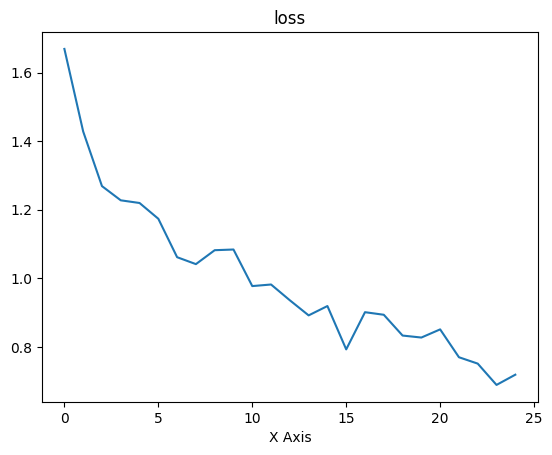

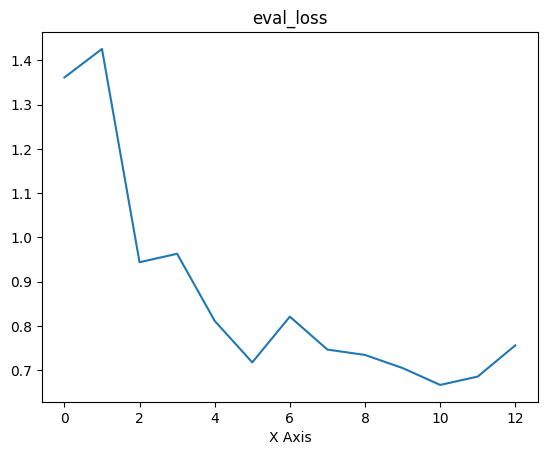

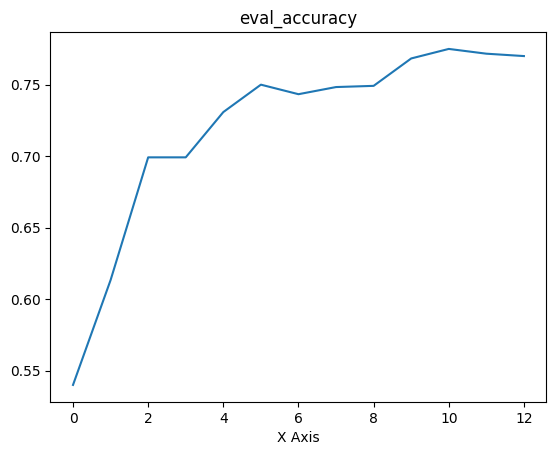

In [158]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for field_name in ['loss','eval_loss','eval_accuracy']:
    trace = [item.get(field_name, None) for item in trainer.state.log_history]
    trace = [x for x in trace if x is not None]
    plt.plot(trace)
    plt.title(field_name)
    plt.xlabel("X Axis")
    plt.show()


In [156]:
def evaluate_and_plot(model_predictions, dataset_name, id2label=model.config.id2label):
    true_labels = model_predictions.label_ids
    preds = np.argmax(model_predictions.predictions, axis=1)
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report = classification_report(true_labels, preds, target_names=target_names)
    print(f"Classification Report for {dataset_name} Dataset:\n")
    print(report)
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix for {dataset_name} Dataset")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


Classification Report for Train Dataset:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       423
           N       0.66      0.78      0.71       423
           S       0.74      0.52      0.61       423
           F       0.67      0.83      0.74       423
           W       0.88      0.61      0.73       423
           H       0.59      0.69      0.64       423

    accuracy                           0.74      2538
   macro avg       0.76      0.74      0.74      2538
weighted avg       0.76      0.74      0.74      2538



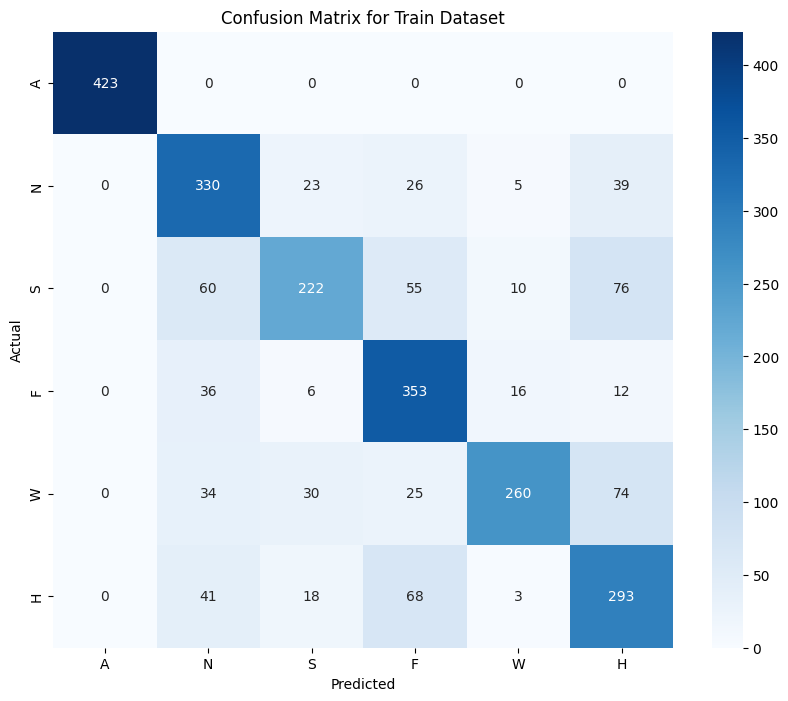

Classification Report for Test Dataset:

              precision    recall  f1-score   support

           A       0.90      1.00      0.95       212
           N       0.75      0.83      0.79       206
           S       0.86      0.40      0.55        90
           F       0.00      0.00      0.00         7
           W       0.73      0.49      0.59        45
           H       0.41      0.55      0.47        40

    accuracy                           0.77       600
   macro avg       0.61      0.54      0.56       600
weighted avg       0.79      0.77      0.76       600



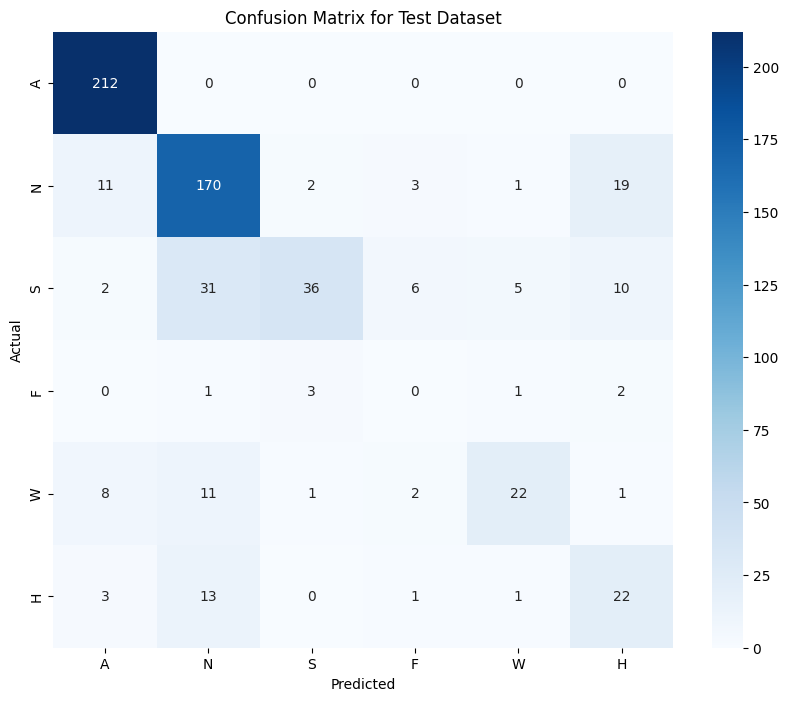

Classification Report for Validation Dataset:

              precision    recall  f1-score   support

           A       0.94      1.00      0.97       424
           N       0.80      0.86      0.83       411
           S       0.75      0.36      0.48       179
           F       0.04      0.06      0.05        16
           W       0.69      0.52      0.59        90
           H       0.36      0.56      0.44        80

    accuracy                           0.78      1200
   macro avg       0.60      0.56      0.56      1200
weighted avg       0.79      0.78      0.77      1200



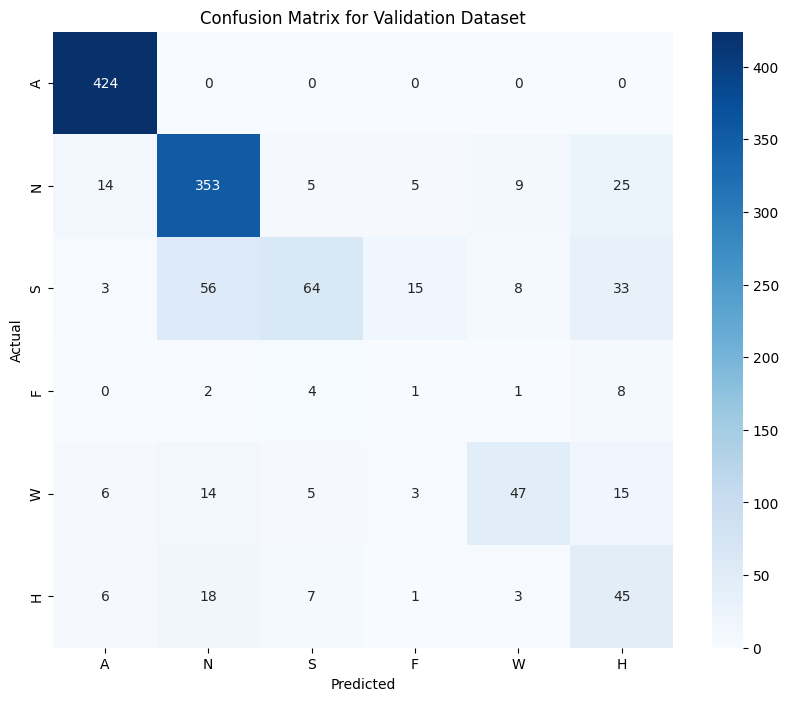

In [157]:
evaluate_and_plot(train_predictions, "Train")
evaluate_and_plot(test_predictions, "Test")
evaluate_and_plot(val_predictions, "Validation")